[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = "XarTw09VRJncVEPwvwBe"

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sat May 31 15:15:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 54.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg


--2025-05-31 15:17:45--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-05-31 15:17:45 (130 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 309MB/s]


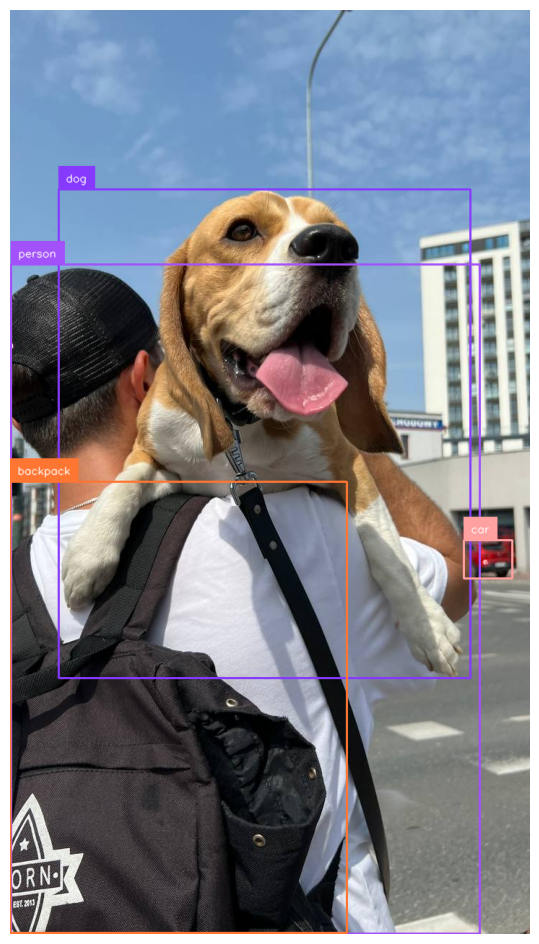

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [7]:
from roboflow import download_dataset
dataset = download_dataset('https://universe.roboflow.com/yokoy-vsmht/traffic-sign-ver2.0/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to traffic-sign-ver2.0-2 in yolov8:: 100%|██████████| 9636/9636 [00:02<00:00, 3857.41it/s]


In [8]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

names:
- D-D
- NoEntry
- NoOvertaking
- NoParking
- OneWay
- Others
- SpeedLimit
- Stop
nc: 8
roboflow:
  license: CC BY 4.0
  project: traffic-sign-ver2.0
  url: https://universe.roboflow.com/yokoy-vsmht/traffic-sign-ver2.0/dataset/2
  version: 2
test: ../test/images
train: ../train/images
val: ../valid/images


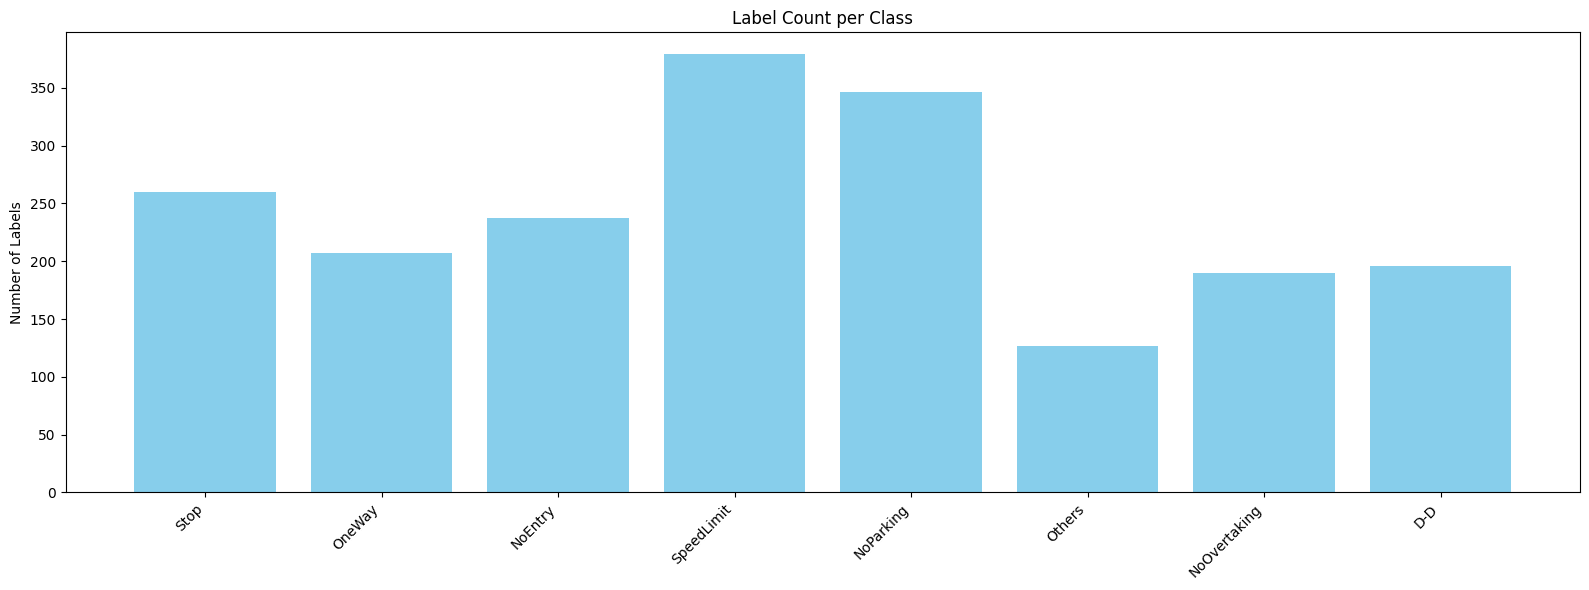

In [14]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# class names
names = [
    'D-D', 'NoEntry', 'NoOvertaking', 'NoParking', 'OneWay',
    'Others', 'SpeedLimit', 'Stop'
]

# 路徑設定
split_dirs = ['/content/traffic-sign-ver2.0-2/test/labels', '/content/traffic-sign-ver2.0-2/valid/labels', '/content/traffic-sign-ver2.0-2/test/labels']
label_counts = defaultdict(int)

# 逐個資料夾讀取標註檔
for dir_path in split_dirs:
    if not os.path.exists(dir_path):
        continue
    for file_name in os.listdir(dir_path):
        if not file_name.endswith('.txt'):
            continue
        with open(os.path.join(dir_path, file_name), 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                label_counts[class_id] += 1

# 將 class_id 映射為名字
category_counts = {names[class_id]: count for class_id, count in label_counts.items()}

# 確保所有類別都顯示（即使為 0）
for name in names:
    category_counts.setdefault(name, 0)

# 畫直方圖
plt.figure(figsize=(16, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Labels")
plt.title("Label Count per Class")
plt.tight_layout()
plt.show()

## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [16]:
from ultralytics import YOLO

model = YOLO('yolov12s.pt')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.pt, data=/content/traffic-sign-ver2.0-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fa

100%|██████████| 5.26M/5.26M [00:00<00:00, 79.3MB/s]


AMP: checks passed ✅


train: Scanning /content/traffic-sign-ver2.0-2/train/labels... 3825 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3825/3825 [00:01<00:00, 2306.75it/s]


train: New cache created: /content/traffic-sign-ver2.0-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/traffic-sign-ver2.0-2/valid/labels... 879 images, 0 backgrounds, 0 corrupt: 100%|██████████| 879/879 [00:00<00:00, 1044.01it/s]

val: New cache created: /content/traffic-sign-ver2.0-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.81G     0.8231      1.516      1.002          1        640: 100%|██████████| 240/240 [02:14<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:12<00:00,  2.17it/s]

                   all        879       1564      0.768      0.821      0.858      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.75G     0.7863     0.7957     0.9826          6        640: 100%|██████████| 240/240 [02:13<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.40it/s]

                   all        879       1564      0.846       0.88      0.921      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       6.9G     0.7809     0.7359     0.9861          1        640: 100%|██████████| 240/240 [02:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.897      0.868      0.926      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.74G     0.7626     0.6754      0.986          8        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.937      0.903      0.944      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       6.9G     0.7362     0.6248     0.9718          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.893      0.922      0.951      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.91G     0.7176     0.5962     0.9654          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all        879       1564      0.887      0.927      0.945      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       6.9G     0.7094      0.569     0.9647          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]

                   all        879       1564      0.918      0.918      0.946      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.74G     0.6926     0.5416     0.9458          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.48it/s]

                   all        879       1564      0.942      0.915      0.957      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       6.9G     0.6757     0.5184     0.9385          0        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.935      0.943      0.967      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       6.9G      0.668     0.5015     0.9428          2        640: 100%|██████████| 240/240 [02:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.938      0.941      0.966      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.91G     0.6613     0.5025     0.9379          5        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.953      0.952      0.966      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.74G     0.6539      0.481     0.9335          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.942      0.945      0.973      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       6.9G     0.6539     0.4711     0.9339          3        640: 100%|██████████| 240/240 [02:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.941      0.954      0.973      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.74G     0.6448     0.4642     0.9268          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.939      0.955      0.978      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.9G     0.6283     0.4523     0.9239          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.45it/s]

                   all        879       1564      0.934      0.956      0.975      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       6.9G     0.6229     0.4402     0.9227          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.925      0.968      0.982      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.91G     0.6109     0.4256     0.9198          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.955      0.961      0.978      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.74G     0.6224     0.4261       0.92          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.45it/s]

                   all        879       1564      0.957      0.972      0.982      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       6.9G     0.6058     0.4111     0.9077          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.951      0.965      0.982      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.74G     0.6017     0.4119     0.9086          7        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.957      0.977      0.984      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       6.9G     0.6071     0.4172     0.9146          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.969      0.977      0.991      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       6.9G     0.5918     0.4005      0.912          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.977      0.968      0.989      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.91G     0.5951     0.3947     0.9104          4        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.959      0.968      0.982       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.74G     0.5746     0.3826     0.9047          2        640: 100%|██████████| 240/240 [02:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.972      0.965      0.987      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       6.9G     0.5757      0.385     0.9048          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.978      0.987      0.991       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.74G     0.5628     0.3725      0.902          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.984      0.965       0.99      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       6.9G      0.566      0.376     0.8989          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.987      0.973      0.991      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       6.9G     0.5543     0.3751     0.8923          0        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.978      0.969       0.99      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.91G      0.554     0.3689     0.8997          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.981      0.982       0.99      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.74G     0.5514     0.3522     0.8938          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.976      0.984      0.992      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       6.9G     0.5486     0.3564     0.8926          0        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.976      0.989      0.991      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.74G     0.5425     0.3578     0.8902          3        640: 100%|██████████| 240/240 [02:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.984      0.986      0.992      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       6.9G     0.5429     0.3493     0.8869          4        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.41it/s]

                   all        879       1564      0.988      0.985      0.993      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       6.9G     0.5417     0.3514     0.8881          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.988      0.982      0.992      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.91G     0.5319     0.3412     0.8914          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.40it/s]

                   all        879       1564      0.984      0.991      0.993      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.74G     0.5213     0.3341     0.8855          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.983      0.992      0.994      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       6.9G      0.517     0.3314     0.8828          5        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564       0.98      0.987      0.989      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.74G     0.5093     0.3294     0.8766          4        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.976      0.988      0.989      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       6.9G     0.5086     0.3242     0.8777          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.984      0.992      0.993      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       6.9G     0.5023     0.3224     0.8751          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.985      0.994      0.992      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.91G     0.4917     0.3162     0.8754          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.45it/s]

                   all        879       1564      0.983      0.992      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.74G     0.4883      0.314     0.8726          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.985      0.991      0.993      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       6.9G     0.4873     0.3157     0.8745          6        640: 100%|██████████| 240/240 [02:07<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.985      0.993      0.993      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.74G     0.4775      0.308     0.8689          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.37it/s]

                   all        879       1564      0.987      0.993      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       6.9G      0.483     0.3088     0.8718          1        640: 100%|██████████| 240/240 [02:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.41it/s]

                   all        879       1564      0.991      0.992      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       6.9G     0.4716     0.3017     0.8709          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.988      0.992      0.993      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.91G     0.4722     0.3018     0.8688          9        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.994      0.994      0.994      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.74G     0.4614     0.2947     0.8631          4        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.994      0.998      0.994      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       6.9G     0.4595     0.2952     0.8624          0        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.994      0.996      0.994      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.74G     0.4604      0.302     0.8645          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.41it/s]

                   all        879       1564      0.989      0.993      0.994      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.9G     0.4586     0.2913     0.8636          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all        879       1564      0.993      0.994      0.994      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       6.9G     0.4483     0.2881     0.8621          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.992      0.996      0.994       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.91G      0.445     0.2863     0.8609          5        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all        879       1564      0.995      0.994      0.994      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.74G     0.4436     0.2857     0.8618          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.994      0.994      0.994      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       6.9G     0.4301     0.2749     0.8544          6        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.995      0.998      0.994      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.74G     0.4258     0.2757     0.8539          4        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.994      0.998      0.994      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       6.9G      0.418     0.2703     0.8465          0        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all        879       1564      0.994      0.998      0.994      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       6.9G     0.4135     0.2642     0.8516          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]

                   all        879       1564      0.996      0.999      0.994      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.91G     0.4109     0.2694     0.8515          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all        879       1564      0.994      0.999      0.994      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.74G     0.4114     0.2687      0.853          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]

                   all        879       1564      0.997      0.995      0.994      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       6.9G     0.4038     0.2665     0.8444          0        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]

                   all        879       1564      0.996      0.998      0.994      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.74G      0.412     0.2772     0.8515          1        640: 100%|██████████| 240/240 [02:07<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.45it/s]

                   all        879       1564      0.996      0.998      0.994      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       6.9G     0.3973     0.2587     0.8474          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]

                   all        879       1564      0.995      0.997      0.994      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       6.9G     0.3975     0.2613     0.8468          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all        879       1564      0.996      0.999      0.994       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.91G     0.3938     0.2597     0.8458          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.51it/s]

                   all        879       1564      0.995      0.999      0.994      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.74G     0.3851     0.2517     0.8471          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]

                   all        879       1564      0.996      0.998      0.994      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       6.9G     0.3772     0.2457     0.8434          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]

                   all        879       1564      0.997      0.999      0.994      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.74G     0.3803     0.2516     0.8433          4        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.50it/s]

                   all        879       1564      0.997      0.999      0.994      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       6.9G     0.3719     0.2422       0.84          4        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.48it/s]

                   all        879       1564      0.996      0.999      0.994      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       6.9G     0.3697     0.2419     0.8361          0        640: 100%|██████████| 240/240 [02:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]

                   all        879       1564      0.995      0.999      0.994      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.91G     0.3692     0.2416     0.8361          2        640: 100%|██████████| 240/240 [02:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.50it/s]

                   all        879       1564      0.995      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.74G     0.3619      0.235     0.8375          4        640: 100%|██████████| 240/240 [02:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]

                   all        879       1564      0.997      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       6.9G     0.3665     0.2396     0.8377          6        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.50it/s]

                   all        879       1564      0.997      0.998      0.994      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.74G     0.3595     0.2379     0.8348          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.45it/s]

                   all        879       1564      0.997      0.999      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       6.9G     0.3539     0.2358     0.8363          5        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.997      0.999      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       6.9G     0.3464     0.2283     0.8312          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.997      0.999      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.91G     0.3442     0.2318     0.8293          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.997      0.999      0.994      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.74G     0.3482     0.2294      0.834          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all        879       1564      0.997      0.999      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       6.9G     0.3395     0.2348     0.8267          0        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all        879       1564      0.998      0.999      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.74G     0.3415     0.2265     0.8289          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.997      0.998      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       6.9G     0.3329     0.2224     0.8291          8        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.998      0.999      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.92G     0.3365     0.2219      0.831          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.998      0.999      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.91G      0.331     0.2195     0.8285          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.41it/s]

                   all        879       1564      0.997      0.999      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.74G     0.3225     0.2123     0.8235          9        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.997      0.999      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       6.9G     0.3206      0.214     0.8259          7        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.996      0.999      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.74G     0.3187     0.2171     0.8266          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.996      0.999      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       6.9G     0.3171      0.211     0.8234          4        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.41it/s]

                   all        879       1564      0.996      0.999      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       6.9G     0.3098     0.2068      0.823          6        640: 100%|██████████| 240/240 [02:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.45it/s]

                   all        879       1564      0.996      0.999      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.91G     0.3096     0.2088     0.8266          2        640: 100%|██████████| 240/240 [02:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.998      0.999      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.74G     0.3059     0.2042     0.8206          2        640: 100%|██████████| 240/240 [02:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.998      0.999      0.995      0.978


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       6.9G     0.2678     0.1667     0.8011          1        640: 100%|██████████| 240/240 [02:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.997      0.999      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.74G     0.2533     0.1596     0.7942          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.997      0.999      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       6.9G     0.2501     0.1544     0.7938          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all        879       1564      0.997      0.999      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       6.9G      0.244     0.1528     0.7877          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.40it/s]

                   all        879       1564      0.998      0.999      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.91G     0.2404     0.1519     0.7889          2        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.39it/s]

                   all        879       1564      0.998      0.999      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.74G     0.2364     0.1491     0.7915          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]

                   all        879       1564      0.998      0.999      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       6.9G     0.2365     0.1535     0.7914          4        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.999      0.999      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.74G     0.2326      0.149     0.7879          1        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.999      0.999      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       6.9G     0.2295     0.1441     0.7865          3        640: 100%|██████████| 240/240 [02:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]

                   all        879       1564      0.999      0.999      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       6.9G     0.2264      0.144     0.7854          2        640: 100%|██████████| 240/240 [02:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all        879       1564      0.998          1      0.995      0.984



100 epochs completed in 3.933 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,077,304 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


                   all        879       1564      0.998          1      0.995      0.983
                   D-D        147        164      0.999          1      0.995      0.979
               NoEntry        125        179      0.999          1      0.995      0.978
          NoOvertaking        162        162          1          1      0.995      0.988
             NoParking        286        286      0.993          1      0.995      0.991
                OneWay        167        177      0.999          1      0.995      0.978
                Others         60        105      0.999          1      0.995       0.98
            SpeedLimit        289        297          1      0.997      0.995      0.989
                  Stop        183        194      0.998          1      0.995      0.986
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [17]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch1.jpg
confusion_matrix_normalized.png			   train_batch21600.jpg
confusion_matrix.png				   train_batch21601.jpg
events.out.tfevents.1748704852.0f0a9f0b7c76.799.0  train_batch21602.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


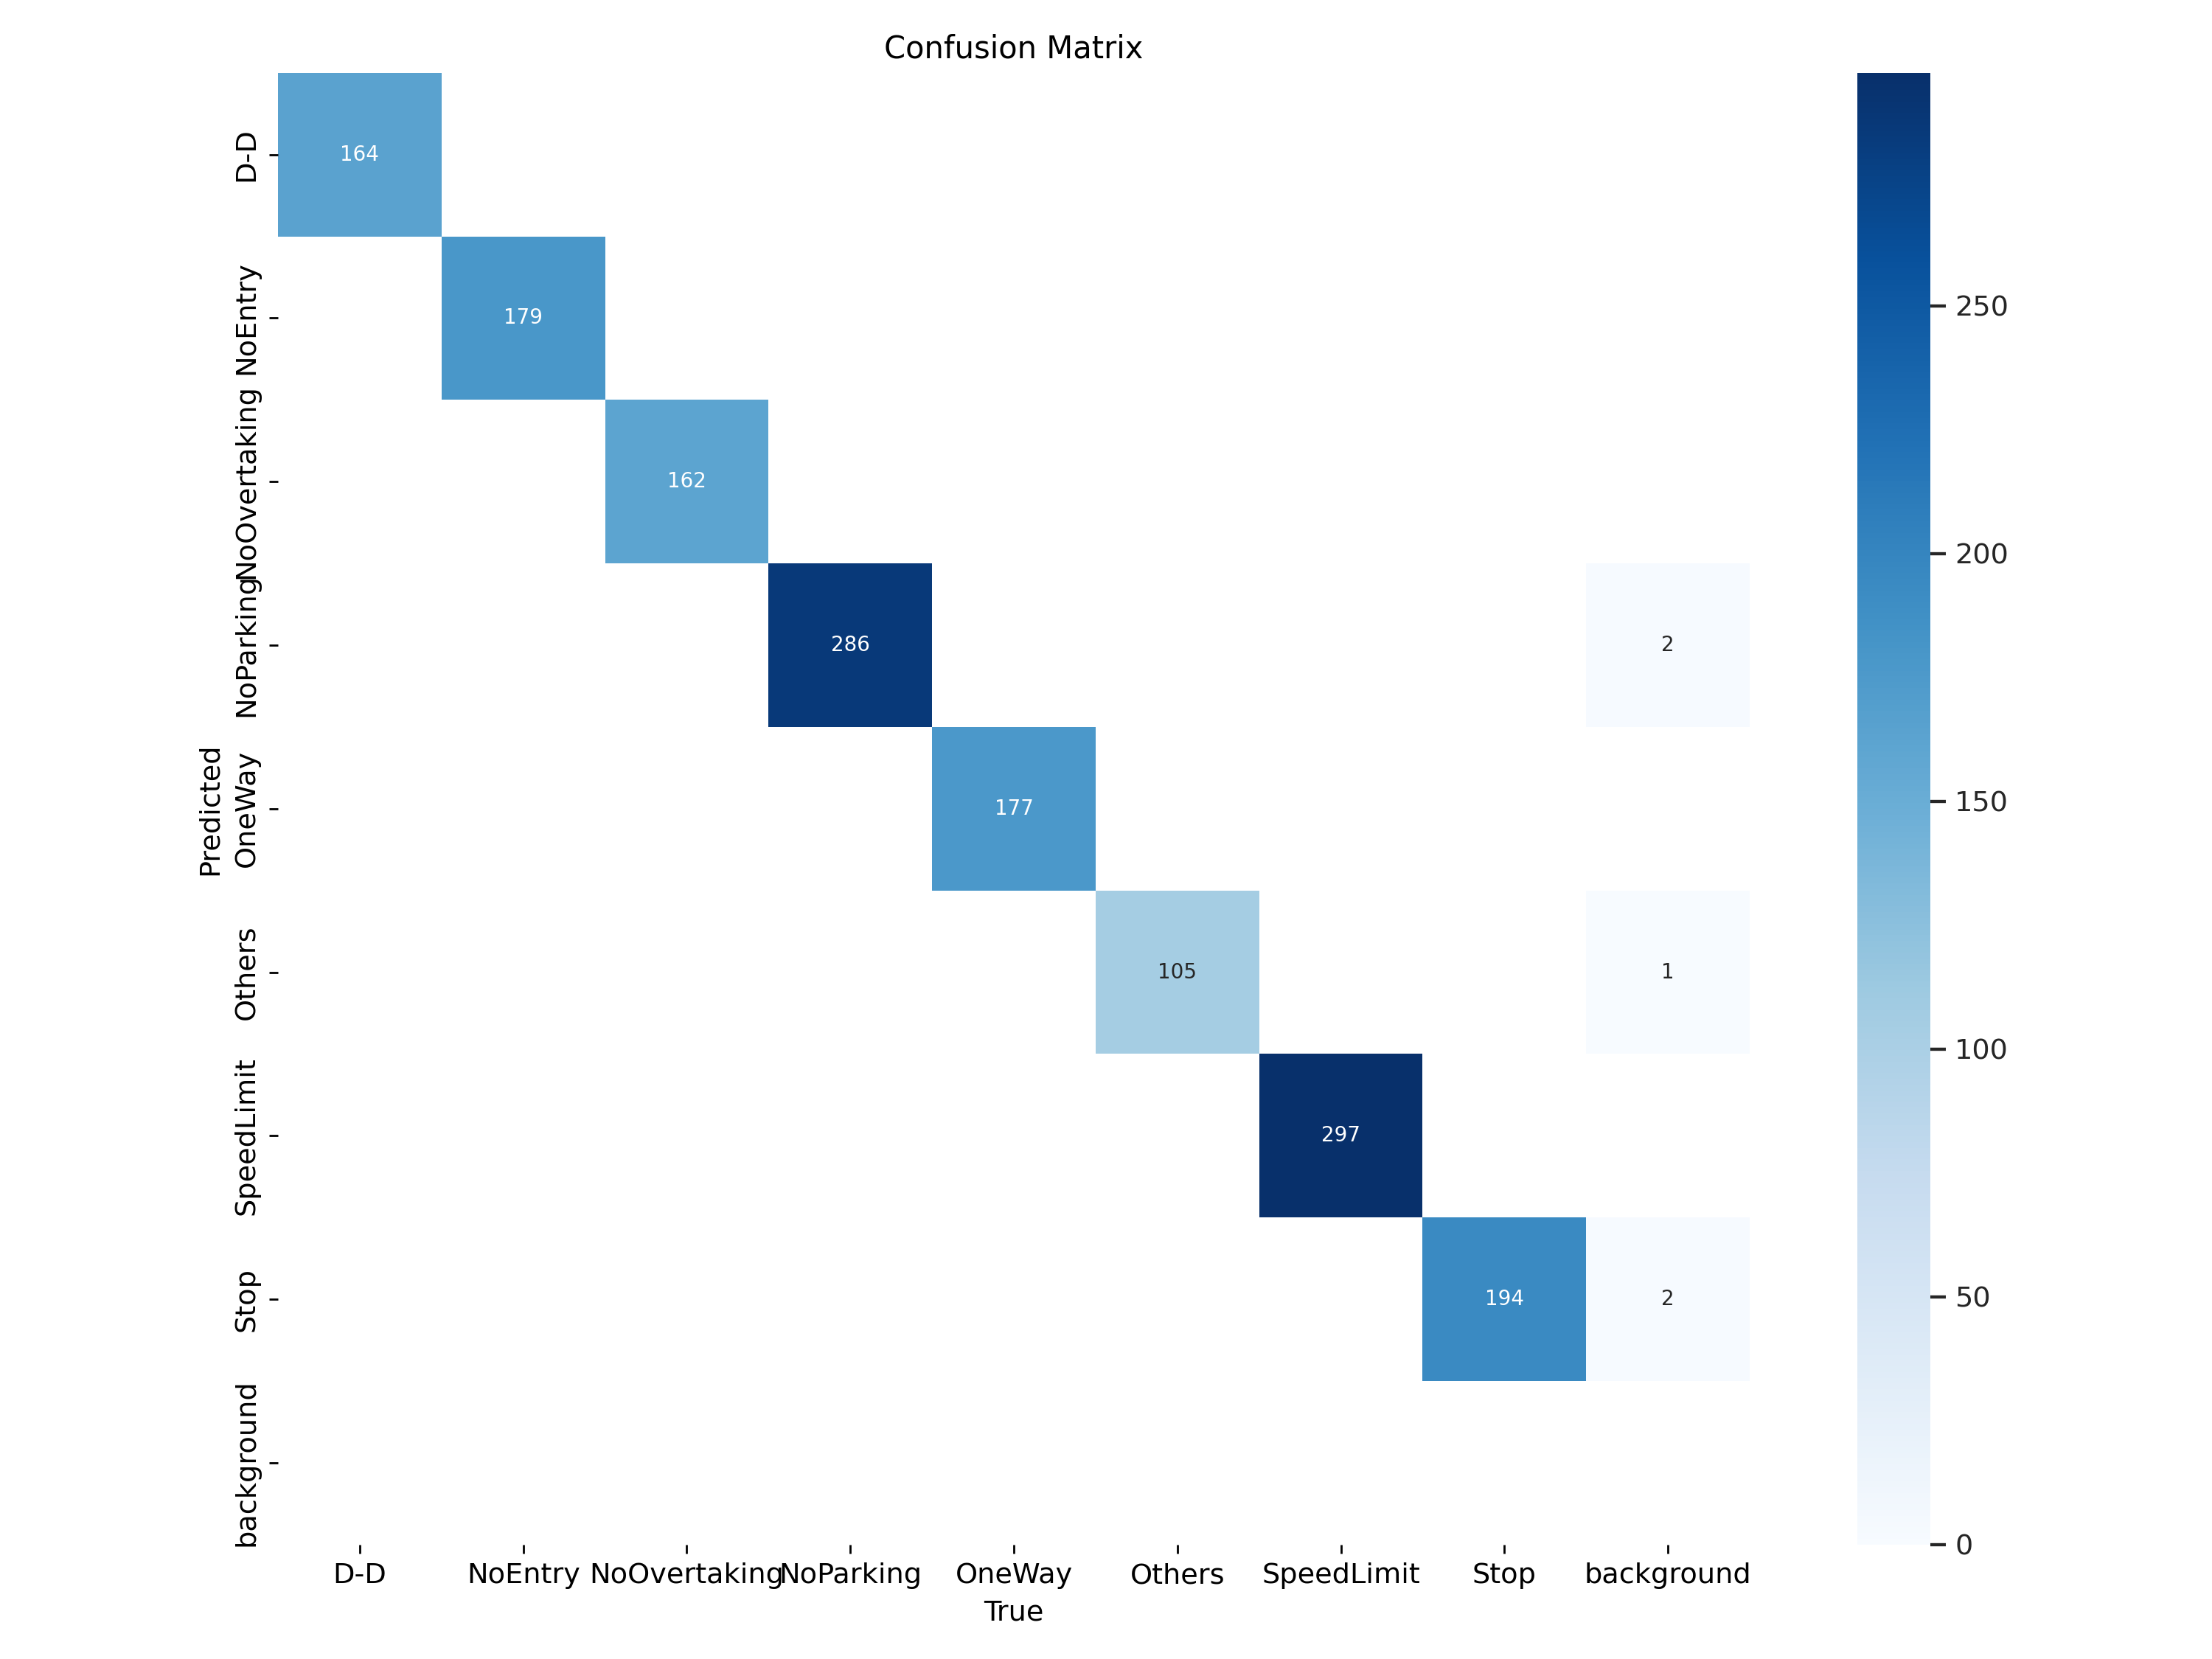

In [18]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

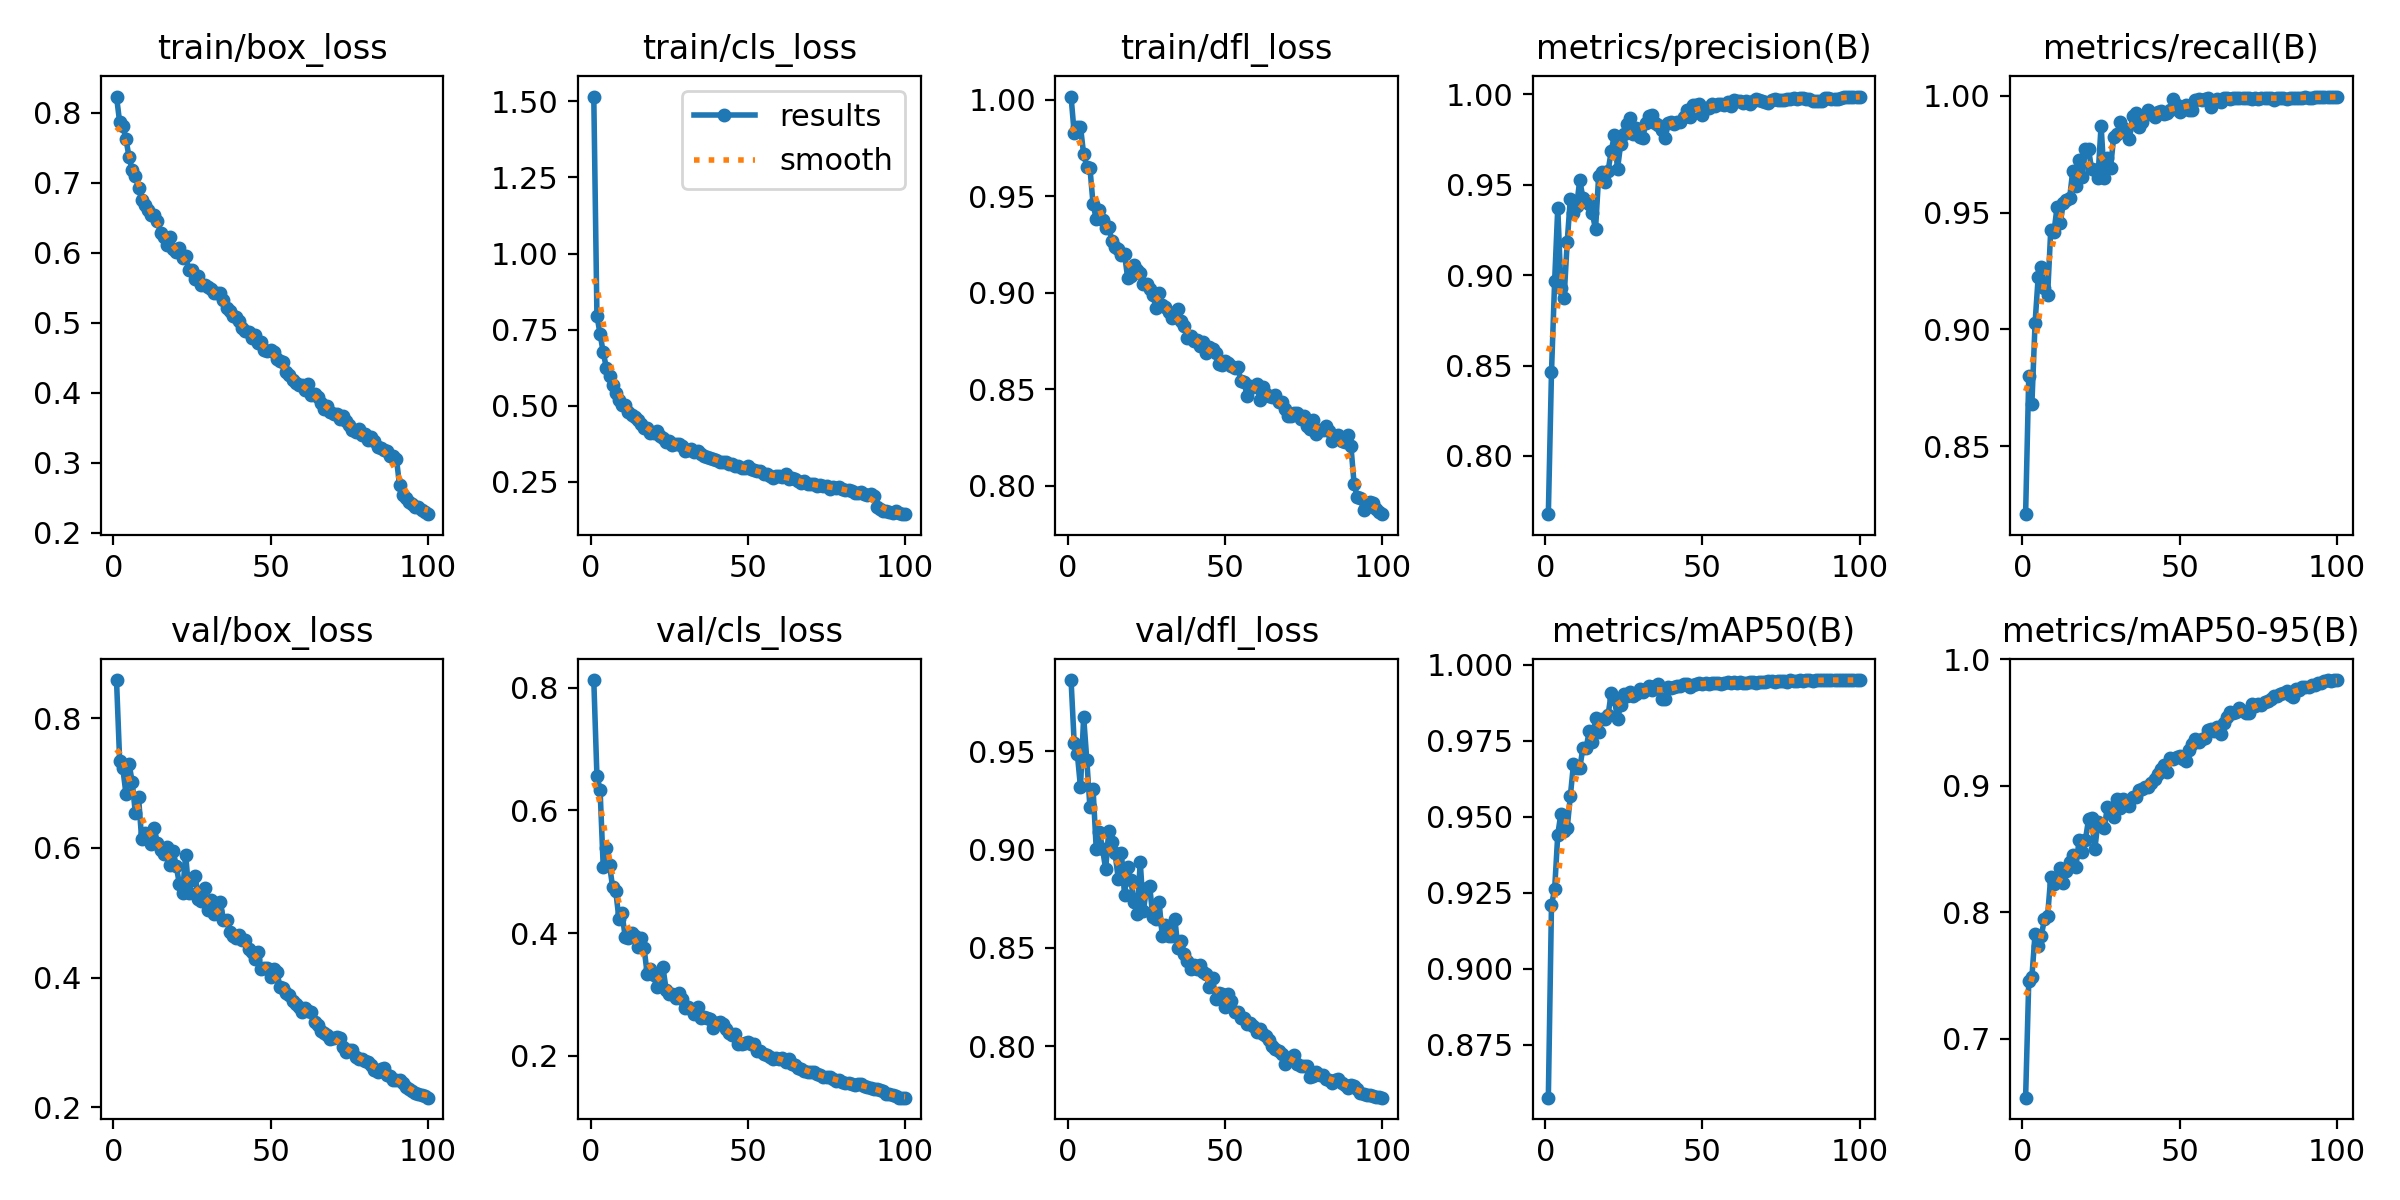

In [19]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [20]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['D-D',
 'NoEntry',
 'NoOvertaking',
 'NoParking',
 'OneWay',
 'Others',
 'SpeedLimit',
 'Stop']

In [21]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [22]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.9796404532299391
mAP 50 0.9999999999999999
mAP 75 0.9999999999999999


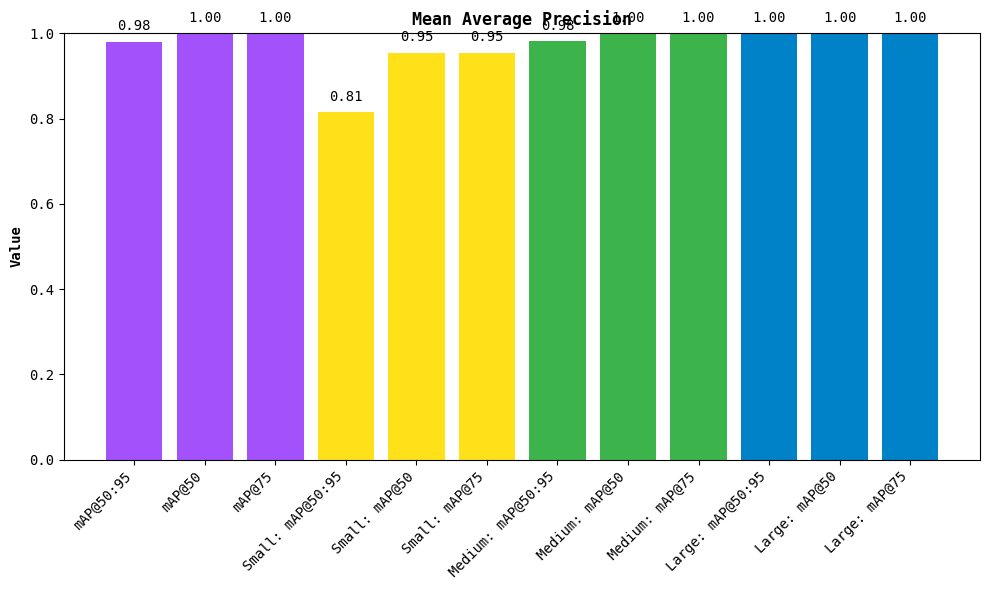

In [23]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [24]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

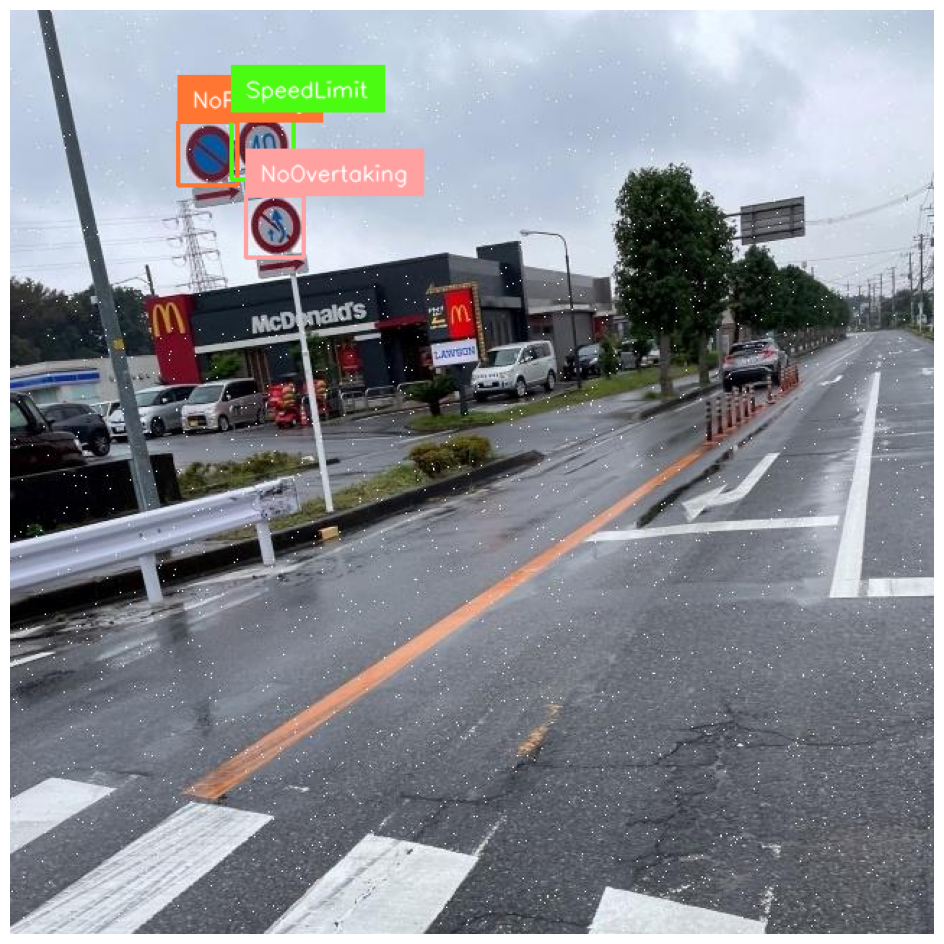

In [37]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Saving dog.jpeg to dog (1).jpeg


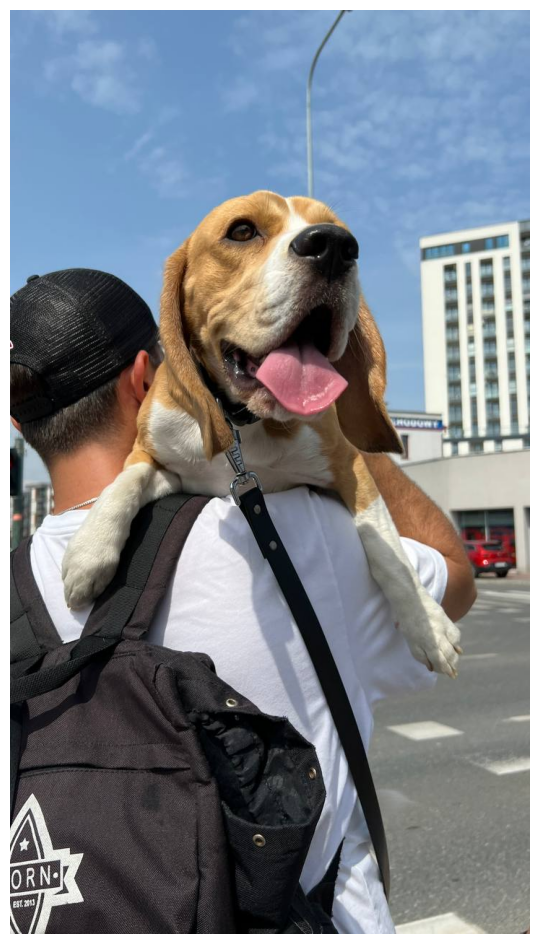

In [39]:
import random
from google.colab import files
from PIL import Image
import cv2
import supervision as sv
from ultralytics import YOLO

# 讓使用者上傳圖片
uploaded = files.upload()

# 取得圖片路徑（假設只上傳一張）
image_path = list(uploaded.keys())[0]

# 載入模型（這裡假設你已經載入好 YOLO 模型）
model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')  # 或你訓練好的模型路徑

# 使用模型做預測
results = model(image_path, verbose=False)[0]

# 取得偵測結果並做 NMS
detections = sv.Detections.from_ultralytics(results).with_nms()

# 使用 OpenCV 讀圖（因為 sv 需要 numpy 陣列）
image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 畫上 bounding box 和 label
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# 顯示結果
sv.plot_image(annotated_image)

In [34]:
import shutil
from google.colab import files

# 將 /content/runs 壓縮成 runs.zip
shutil.make_archive('/content/runs', 'zip', '/content/runs')

# 下載 runs.zip
files.download('/content/runs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import shutil
import os

# 確認資料夾存在後再刪除
runs_path = '/content/runs'
if os.path.exists(runs_path):
    shutil.rmtree(runs_path)
    print(f"{runs_path} 已成功刪除。")
else:
    print(f"{runs_path} 不存在，無需刪除。")


/content/runs 已成功刪除。


In [ ]:
from roboflow import download_dataset
dataset = download_dataset('https://universe.roboflow.com/yokoy-vsmht/traffic-sign-ver2.0/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to traffic-sign-ver2.0-2 in yolov8:: 100%|██████████| 9636/9636 [00:01<00:00, 5406.40it/s]
